<a href="https://colab.research.google.com/github/Savith-02/notebooks/blob/main/rnn_intent_classifier/rnn_intent_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
def read_dataset(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            intent, sentence = line.strip().split(',')
            data.append((intent.strip(), sentence.strip()))
    return data

# Example usage
file_path = "data.txt"  # Replace with the path to your dataset file
dataset = read_dataset(file_path)[1:]
print(dataset[:10])

[('Greet', 'Hi'), ('Greet', 'Hello'), ('Greet', 'Hey there'), ('Greet', 'Good morning'), ('Greet', 'Howdy'), ('Greet', 'Hi there'), ('Greet', 'Hey'), ('Greet', 'Good afternoon'), ('Greet', 'Hello there'), ('Greet', 'Hi how can I help you?')]


In [11]:
split = round(len(dataset) * 60 / 100)
training_data = dataset[:split]
cv_data = dataset[split:]

In [12]:
intent_counts = {}
for intent, _ in dataset:
    if intent not in intent_counts:
        intent_counts[intent] = 0
    intent_counts[intent] += 1
print(intent_counts)

{'Greet': 53, 'Farewell': 66, 'Inquiry': 50, 'Feedback': 50, 'Complaint': 38, 'Request': 50, 'Navigation': 58}


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim as optim


# Define the vocabulary
all_chars = set(''.join([sentence for intent, sentence in dataset]))
char_to_index = {char: i for i, char in enumerate(all_chars)}
index_to_char = {i: char for char, i in char_to_index.items()}
num_chars = len(all_chars)

all_intents = set(intent for intent, _ in dataset[1:])
intent_to_index = {intent: i for i, intent in enumerate(all_intents)}
index_to_intent = {i: intent for intent, i in intent_to_index.items()}
num_intents = len(all_intents)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert sentences to tensors
def sentence_to_tensor(sentence):
    tensor = torch.zeros(len(sentence), 1, num_chars).to(device)
    for i, char in enumerate(sentence):
        tensor[i][0][char_to_index[char]] = 1
    return tensor

# Convert intents to tensors
def intent_to_tensor(intent):
    return torch.tensor([intent_to_index[intent]], dtype=torch.long).to(device)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        hidden = self.init_hidden()
        output, _ = self.rnn(input, hidden)
        output = self.fc(output[-1])
        output = self.softmax(output)
        return output

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)

In [14]:
print(all_intents)
print(intent_to_index)

{'Feedback', 'Inquiry', 'Greet', 'Request', 'Complaint', 'Farewell', 'Navigation'}
{'Feedback': 0, 'Inquiry': 1, 'Greet': 2, 'Request': 3, 'Complaint': 4, 'Farewell': 5, 'Navigation': 6}


In [15]:
# # Define hyperparameters
# hidden_size = 128
# learning_rate = 0.001
# epochs = 100

# # Initialize the model
# model = RNN(num_chars, hidden_size, num_intents)
# model.to(device)

# loss_function = nn.NLLLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# # Training loop with loss plotting
# losses = []
# for epoch in range(epochs):
#     total_loss = 0
#     for intent, sentence in dataset:
#         model.zero_grad()
#         intent_tensor = intent_to_tensor(intent)
#         sentence_tensor = sentence_to_tensor(sentence)
#         output = model(sentence_tensor)
#         loss = loss_function(output, intent_tensor)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     scheduler.step()
#     losses.append(total_loss)
#     if (epoch + 1) % 10 == 0:
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

# # Plot the loss
# plt.plot(losses)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.show()


In [19]:

def train_rnn(model, training_data, cv_data, intent_to_tensor, sentence_to_tensor, device, hidden_size, learning_rate, epochs):

    # Initialize the model
    model = model(num_chars, hidden_size, num_intents)
    model.to(device)

    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Training loop with loss plotting
    losses = []
    cv_losses = []
    training_dataset_len = len(training_data)
    cv_dataset_len = len(cv_data)

    for epoch in range(epochs):
        total_loss = 0

        for intent, sentence in training_data:
            model.zero_grad()
            intent_tensor = intent_to_tensor(intent)
            sentence_tensor = sentence_to_tensor(sentence)
            output = model(sentence_tensor)
            loss = loss_function(output, intent_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        # losses.append(total_loss / training_dataset_len)
        losses.append(total_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

        total_cv_loss = 0
        with torch.no_grad():
          for intent, sentence in cv_data:
              intent_tensor = intent_to_tensor(intent)
              sentence_tensor = sentence_to_tensor(sentence)
              output = model(sentence_tensor)
              loss = loss_function(output, intent_tensor)
              total_cv_loss += loss.item()

          cv_losses.append(total_cv_loss)

    # Plot the loss
    # plt.plot(losses)
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Training Loss')
    # plt.show()

    return losses, cv_losses

In [20]:
losses_container = []
learning_rates = [0.001, 0.003, 0.01, 0.03, 0.1]
num = len(learning_rates)


for i in range(num):
  loss_arr, cv_loss_arr = train_rnn(
    model=RNN,
    training_data=training_data,
    cv_data=cv_data,
    intent_to_tensor=intent_to_tensor,
    sentence_to_tensor=sentence_to_tensor,
    device=device,
    hidden_size=128,
    learning_rate=learning_rates[i],
    epochs=100
  )
  losses_container.append([loss_arr, cv_loss_arr])


Epoch 10/100, Loss: 134.05185102298856
Epoch 20/100, Loss: 44.18909252481535
Epoch 30/100, Loss: 17.541300538694486
Epoch 40/100, Loss: 11.254819252411835
Epoch 50/100, Loss: 9.135595016588923
Epoch 60/100, Loss: 8.408594856678974
Epoch 70/100, Loss: 8.153412984276656
Epoch 80/100, Loss: 8.064205047499854
Epoch 90/100, Loss: 8.033126668597106
Epoch 100/100, Loss: 8.022349145030603
Epoch 10/100, Loss: 241.9325091689825
Epoch 20/100, Loss: 141.29110092297196
Epoch 30/100, Loss: 112.3881018832326
Epoch 40/100, Loss: 99.09163154661655
Epoch 50/100, Loss: 92.88483892381191
Epoch 60/100, Loss: 90.5068745254539
Epoch 70/100, Loss: 89.64907809672877
Epoch 80/100, Loss: 89.3474419103004
Epoch 90/100, Loss: 89.24210113380104
Epoch 100/100, Loss: 89.20538705773652
Epoch 10/100, Loss: 329.9596947423124
Epoch 20/100, Loss: 127.62232901062816
Epoch 30/100, Loss: 109.51215953519568
Epoch 40/100, Loss: 109.28297672560439
Epoch 50/100, Loss: 102.19152333308011
Epoch 60/100, Loss: 99.24587672296911
Epoc

In [ ]:
# len(losses_container)

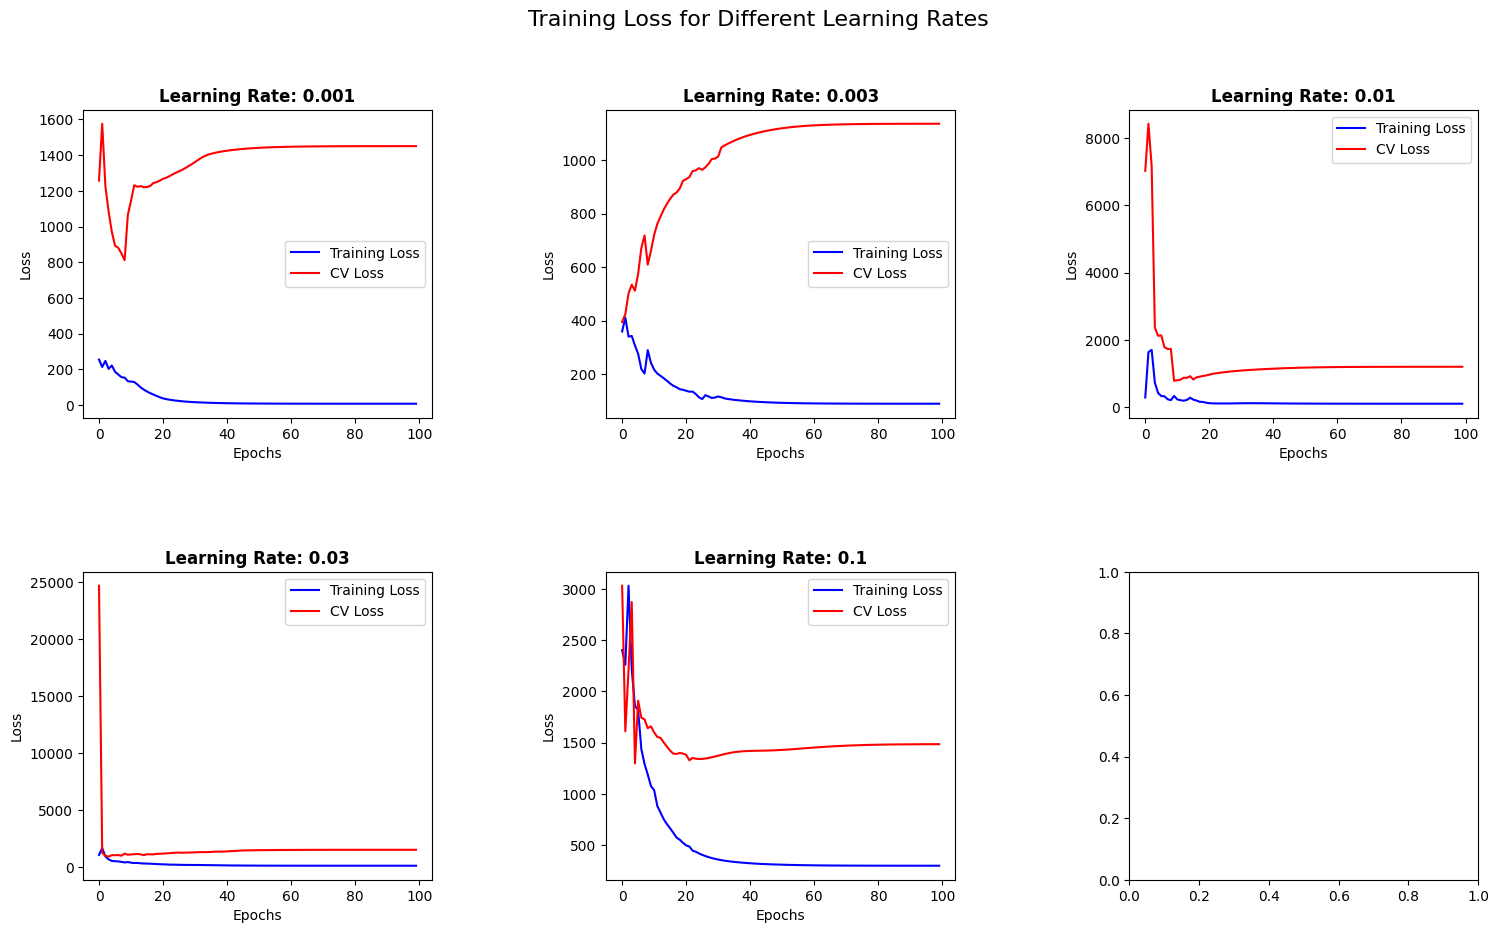

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training Loss for Different Learning Rates', fontsize=16)

for i in range(2):
    for j in range(3):
      if i == 1 and j == 2:
        continue
      ax[i][j].plot(losses_container[i * 3 + j][0], label='Training Loss', color='b')
      ax[i][j].plot(losses_container[i * 3 + j][1], label='CV Loss', color='r')
      ax[i][j].set_title(f'Learning Rate: {learning_rates[i * 3 + j]}', fontsize=12, fontweight='bold')
      ax[i][j].set_xlabel('Epochs')
      ax[i][j].set_ylabel('Loss')
      ax[i][j].legend()

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [25]:
# Test the model
def predict_intent(sentence):
    with torch.no_grad():
        output = model(sentence_to_tensor(sentence))
        _, predicted_index = torch.max(output, 1)
        predicted_intent = index_to_intent[predicted_index.item()]
        return predicted_intent

# Example usage
test_sentence = "How are you?"
print("Predicted intent:", predict_intent(test_sentence))

NameError: name 'model' is not defined

In [ ]:
# all_intents

In [ ]:
# char_to_index.items()

In [26]:
loss_arr, cv_arr = train_rnn(
    model=RNN,
    training_data=training_data,
    cv_data=cv_data,
    intent_to_tensor=intent_to_tensor,
    sentence_to_tensor=sentence_to_tensor,
    device=device,
    hidden_size=254,
    learning_rate=0.0001,
    epochs=100
  )

Epoch 10/100, Loss: 255.99839437007904
Epoch 20/100, Loss: 201.6094135940075
Epoch 30/100, Loss: 179.68175148963928
Epoch 40/100, Loss: 171.7933434098959
Epoch 50/100, Loss: 169.09452857077122
Epoch 60/100, Loss: 168.16548711061478
Epoch 70/100, Loss: 167.84338326752186
Epoch 80/100, Loss: 167.7313960045576
Epoch 90/100, Loss: 167.69250193238258
Epoch 100/100, Loss: 167.67986407876015


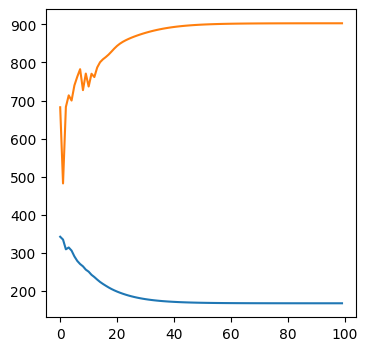

In [27]:
plt.figure(figsize=(4, 4))
plt.plot(loss_arr)
plt.plot(cv_arr)
plt.show()

In [28]:
class RNN_regularised(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, l2_reg=0.001):
        super(RNN_regularised, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.l2_reg = l2_reg

    def forward(self, input):
        hidden = self.init_hidden()
        output, _ = self.rnn(input, hidden)
        output = self.fc(output[-1])
        output = self.softmax(output)
        return output

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)


In [29]:
import numpy as np
def train_rnn_regularised(model, training_data, cv_data, intent_to_tensor, sentence_to_tensor, device, hidden_size, learning_rate, epochs, l2_reg):

    # Initialize the model
    model = model(num_chars, hidden_size, num_intents, l2_reg)
    model.to(device)

    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=model.l2_reg)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Training loop with loss plotting
    losses = []
    cv_losses = []
    training_dataset_len = len(training_data)
    cv_dataset_len = len(cv_data)
    prediction_accuracy = np.zeros((len(all_intents), 2))

    for epoch in range(epochs):
        total_loss = 0

        for intent, sentence in training_data:
            model.zero_grad()
            intent_tensor = intent_to_tensor(intent)
            sentence_tensor = sentence_to_tensor(sentence)
            output = model(sentence_tensor)

            prediction_accuracy[intent_tensor][0] += 1 #[torch.argmax(output)]
            if torch.argmax(output) == intent_tensor:
              prediction_accuracy[intent_tensor][1] += 1

            loss = loss_function(output, intent_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        losses.append(total_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

        print(f"epoch {epoch}: \n{prediction_accuracy}")

        total_cv_loss = 0
        with torch.no_grad():
          for intent, sentence in cv_data:
              intent_tensor = intent_to_tensor(intent)
              sentence_tensor = sentence_to_tensor(sentence)
              output = model(sentence_tensor)
              loss = loss_function(output, intent_tensor)
              total_cv_loss += loss.item()

          cv_losses.append(total_cv_loss)

    return losses, cv_losses

In [30]:
 loss_arr, cv_loss_arr = train_rnn_regularised(
    model=RNN_regularised,
    training_data=training_data,
    cv_data=cv_data,
    intent_to_tensor=intent_to_tensor,
    sentence_to_tensor=sentence_to_tensor,
    device=device,
    hidden_size=350,
    learning_rate=0.0001,
    epochs=100,
    l2_reg=0.008
  )

epoch 0: 
[[50. 25.]
 [50. 27.]
 [53. 46.]
 [ 0.  0.]
 [ 0.  0.]
 [66. 42.]
 [ 0.  0.]]
epoch 1: 
[[100.  37.]
 [100.  52.]
 [106.  77.]
 [  0.   0.]
 [  0.   0.]
 [132.  87.]
 [  0.   0.]]
epoch 2: 
[[150.  53.]
 [150.  77.]
 [159.  89.]
 [  0.   0.]
 [  0.   0.]
 [198. 123.]
 [  0.   0.]]
epoch 3: 
[[200.  76.]
 [200.  95.]
 [212.  92.]
 [  0.   0.]
 [  0.   0.]
 [264. 158.]
 [  0.   0.]]
epoch 4: 
[[250. 102.]
 [250. 124.]
 [265.  94.]
 [  0.   0.]
 [  0.   0.]
 [330. 186.]
 [  0.   0.]]
epoch 5: 
[[300. 137.]
 [300. 157.]
 [318.  97.]
 [  0.   0.]
 [  0.   0.]
 [396. 220.]
 [  0.   0.]]
epoch 6: 
[[350. 183.]
 [350. 187.]
 [371. 105.]
 [  0.   0.]
 [  0.   0.]
 [462. 260.]
 [  0.   0.]]
epoch 7: 
[[400. 226.]
 [400. 215.]
 [424. 115.]
 [  0.   0.]
 [  0.   0.]
 [528. 309.]
 [  0.   0.]]
epoch 8: 
[[450. 269.]
 [450. 243.]
 [477. 124.]
 [  0.   0.]
 [  0.   0.]
 [594. 362.]
 [  0.   0.]]
Epoch 10/100, Loss: 253.40645515918732
epoch 9: 
[[500. 313.]
 [500. 273.]
 [530. 134.]
 [  0.  

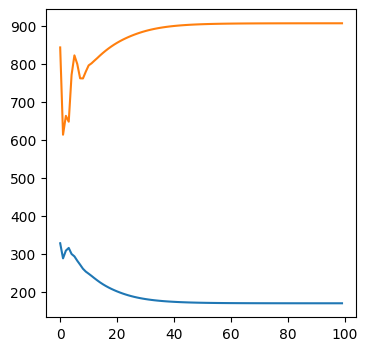

In [31]:
plt.figure(figsize=(4, 4))
plt.plot(loss_arr)
plt.plot(cv_loss_arr)
plt.show()